In [104]:
#Import read a variable from a file
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import preprocessing
import pylab as pl
import matplotlib as plt
%pylab inline

import json
import scipy.stats as sp

# $pip install graphviz
from sklearn.tree import export_graphviz

Populating the interactive namespace from numpy and matplotlib


# Project Workflow:
1. Import and read in Parks Property Information.
2. Import and read in Capital Tracker data.
3. Merge datasets.
4. Calculate days delayed in procurement.
5. Plot frequency of delayed projects.
6. Clean and reframe for random forest analysis.
7. Run random forest analysis.
8. Plot significance levels.

## Objective: 
Deterime significance factors in delayed captial projects throughout the procurement phase.

## 1. Import and read in Parks Property Information.

In [2]:
#get parks property info
!wget https://data.cityofnewyork.us/api/views/p7jc-c8ak/rows.json

--2017-12-14 11:53:18--  https://data.cityofnewyork.us/api/views/p7jc-c8ak/rows.json
Resolving data.cityofnewyork.us... 52.206.140.199
Connecting to data.cityofnewyork.us|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: “rows.json.5”

    [     <=>                               ] 6,988,653   6.86M/s   in 1.0s    

2017-12-14 11:53:20 (6.86 MB/s) - “rows.json.5” saved [6988653]



In [3]:
#Read Park Property info
PPI = open("rows.json").read()
#PPI = pd.read_json(PPI)
PPI = json.loads(PPI)
PPI = json.load(open('rows.json', 'r'))

In [4]:
#Read Parks Property Info from CSV
PPI = pd.read_csv("DPR_ParksProperties_001.csv")
PPI.head()

,OBJECTID,the_geom,GISPROPNUM,OMPPROPID,DEPARTMENT,PERMITDIST,PERMITPARE,PARENTID,LOCATION,COMMUNITYB,...,PERMIT,SIGNNAME,SUBCATEGOR,TYPECATEGO,URL,WATERFRONT,NYS_ASSEMB,NYS_SENATE,US_CONGRES,GlobalID
0,4833,MULTIPOLYGON (((-73.99480296284752 40.70098615...,B223G,B223G,B-02,B-02,B-02,B-02,"Columbia Hts., Hicks St., bet. Middagh St. and...",302,...,N,Hillside Park,Sitting Area/Triangle/Mall,Neighborhood Park,http://www.nycgovparks.org/parks/B223G/,No,52,26,7,{11C07592-A07B-4D38-8EAF-4E0F4C236E43}
1,5284,MULTIPOLYGON (((-73.92183130698453 40.68765103...,B499,B499,B-03,B-03,B-03,B-03,Madison St. between Ralph Ave. and Howard Ave.,303,...,N,Madison Community Greenthumb,Greenthumb,Garden,http://www.nycgovparks.org/parks/B499/,No,55,25,8,{EE66CE51-2049-4BED-BF9F-1975592CAED1}
2,5892,MULTIPOLYGON (((-73.74480569872354 40.71601393...,Q208,Q208,Q-13,Q-13,Q-13,Q-13,"Jamaica Ave., Hempstead Ave. bet. 212 Pl and 2...",413,...,Y,Litchhult Square,Sitting Area/Triangle/Mall,Triangle/Plaza,http://www.nycgovparks.org/parks/Q208/,No,33,14,5,{44A9AB77-4FE7-45A3-8F76-73B1775A3CC0}
3,6343,MULTIPOLYGON (((-73.76706991783179 40.61566721...,Q309,Q309,Q-14,Q-14,Q-14,Q-14,Mott Basin to the City Line,414,...,N,Jamaica Bay Park,Large Park,Nature Area,http://www.nycgovparks.org/parks/Q309/,Yes,"23, 31",10,5,{F9A74B6F-C6B9-4332-81A8-ED8126BC829C}
4,5087,MULTIPOLYGON (((-73.95892335421298 40.70964031...,B167A,B167A,B-01,B-01,B-01,B-01,"S. 5 St., Broadway, Havemeyer St.",301,...,Y,La Guardia Playground,Neighborhood Plgd,Recreation Field/Courts,http://www.nycgovparks.org/parks/B167A/,No,53,18,7,{60DDEDCA-2D41-455F-8583-FA73F6CA37FD}


In [5]:
PPI.columns

Index([u'OBJECTID', u'the_geom', u'GISPROPNUM', u'OMPPROPID', u'DEPARTMENT',
       u'PERMITDIST', u'PERMITPARE', u'PARENTID', u'LOCATION', u'COMMUNITYB',
       u'COUNCILDIS', u'PRECINCT', u'ZIPCODE', u'BOROUGH', u'ACRES',
       u'RETIRED', u'EAPPLY', u'PIP_RATABL', u'GISOBJID', u'CLASS',
       u'COMMISSION', u'ACQUISITIO', u'ADDRESS', u'JURISDICTI', u'MAPPED',
       u'NAME311', u'PERMIT', u'SIGNNAME', u'SUBCATEGOR', u'TYPECATEGO',
       u'URL', u'WATERFRONT', u'NYS_ASSEMB', u'NYS_SENATE', u'US_CONGRES',
       u'GlobalID'],
      dtype='object')

In [52]:
PPI.shape

(2008, 36)

## 2. Import and read in Capital Tracker data.

In [6]:
#Get Capital Tracker Json file
!wget https://www.nycgovparks.org/bigapps/DPR_CapitalProjectTracker_001.json

--2017-12-14 12:25:45--  https://www.nycgovparks.org/bigapps/DPR_CapitalProjectTracker_001.json
Resolving www.nycgovparks.org... 34.226.169.160, 34.197.252.84
Connecting to www.nycgovparks.org|34.226.169.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1364436 (1.3M) [application/octet-stream]
Saving to: “DPR_CapitalProjectTracker_001.json.1”

100%[======================================>] 1,364,436   --.-K/s   in 0.08s   

2017-12-14 12:25:46 (16.9 MB/s) - “DPR_CapitalProjectTracker_001.json.1” saved [1364436/1364436]



In [8]:
#read in Json file for capital tracker
df = pd.read_json("DPR_CapitalProjectTracker_001.json")

In [9]:
df.head(100)

,Attachment,Boroughs,ConstructionActualCompletion,ConstructionAdjustedCompletion,ConstructionPercentComplete,ConstructionProjectedCompletion,ConstructionStart,CurrentPhase,DesignActualCompletion,DesignAdjustedCompletion,...,ProcurementAdjustedCompletion,ProcurementPercentComplete,ProcurementProjectedCompletion,ProcurementStart,ProjectLiaison,ProjectUpdate,Summary,Title,TotalFunding,TrackerID
0,,{u'Borough': [u'Queens']},,,0.00,08/2017,03/2017,construction,09/2015,,...,,100,09/2016,04/2016,Joanne Amagrande,NaN,This project will reconstruct the playground a...,Arrow Recreation Center Playground Reconstruction,"$150,000",1004111
1,,{u'Borough': [u'Brooklyn']},,,0.00,,,proposed,,,...,,0,,,,NaN,This project will reconstruct mechanical & ele...,Abe Stark Ice Rink Reconstruction (Hurricane S...,"Less than $500,000",7121
2,,"{u'Borough': [u'Bronx', u'Queens']}",,,79.00,04/2019,04/2016,construction,02/2014,01/2014,...,05/2016,100,11/2014,02/2014,Cristin Leoutsakos,NaN,This multisite contract will reconstruct roofi...,Bronx and Queens Roofing Systems Reconstructio...,"$693,000",6259
3,,"{u'Borough': [u'Manhattan', u'Queens', u'Brook...",,,0.00,09/2020,09/2017,construction,03/2015,07/2014,...,08/2016,100,12/2015,03/2015,Cristin Leoutsakos,NaN,This project will construct comfort stations a...,Citywide Electrical System Reconstruction for ...,"$865,000",6588
4,,"{u'Borough': [u'Manhattan', u'Queens', u'Brook...",,,0.00,,,design,,07/2014,...,,0,,,Cristin Leoutsakos,The project is delayed because we are re-biddi...,This project will reconstruct comfort stations...,Citywide Comfort Station and Park Facility Rec...,Between $1 million and $3 million,6594
5,http://media.nycgovparks.org/images/common_ima...,{u'Borough': [u'Manhattan']},,,0.00,,,design,,02/2018,...,,0,,,Steve Simon,NaN,This project will reconstruct the comfort stat...,Abraham Lincoln Playground Comfort Station Rec...,Between $1 million and $3 million,8683
6,,"{u'Borough': [u'Manhattan', u'Queens', u'Bronx...",06/2017,06/2017,100.00,09/2016,09/2013,completed,03/2011,,...,,100,11/2011,03/2011,Cristin Leoutsakos,NaN,This multisite contract will reconstruct deter...,Citywide Pool Structural Systems Reconstructio...,"$600,000",5055
7,,{u'Borough': [u'Manhattan']},,,0.00,,,design,,11/2017,...,,0,,,Steve Simon,NaN,This project will reconstruct Abraham Lincoln ...,Abraham Lincoln Playground Reconstruction,Between $3 million and $10 million,8613
8,,{u'Borough': [u'Queens']},10/2014,10/2014,100.00,01/2015,01/2013,completed,08/2011,07/2012,...,,100,05/2012,08/2011,Joanne Amagrande,NaN,This multisite contract will reconstruct play ...,Queens General Site Work (QG-112M),"$3,031,000",3529
9,http://media.nycgovparks.org/images/common_ima...,{u'Borough': [u'Bronx']},,,4.50,07/2018,07/2017,construction,04/2016,04/2016,...,06/2017,100,01/2017,04/2016,Michelle Martell,NaN,This project will reconstruct the sports court...,Agnes Haywood Park Basketball Court Reconstruc...,"$2,800,000",4514


In [10]:
df.columns

Index([u'Attachment', u'Boroughs', u'ConstructionActualCompletion',
       u'ConstructionAdjustedCompletion', u'ConstructionPercentComplete',
       u'ConstructionProjectedCompletion', u'ConstructionStart',
       u'CurrentPhase', u'DesignActualCompletion', u'DesignAdjustedCompletion',
       u'DesignPercentComplete', u'DesignProjectedCompletion', u'DesignStart',
       u'FMSID', u'FundingSources', u'LastUpdated', u'Locations',
       u'ProcurementActualCompletion', u'ProcurementAdjustedCompletion',
       u'ProcurementPercentComplete', u'ProcurementProjectedCompletion',
       u'ProcurementStart', u'ProjectLiaison', u'ProjectUpdate', u'Summary',
       u'Title', u'TotalFunding', u'TrackerID'],
      dtype='object')

In [12]:
# Drop unnecssary columns 
df_pro = df.drop([u'ConstructionActualCompletion',
       u'ConstructionAdjustedCompletion', u'ConstructionPercentComplete',
       u'ConstructionProjectedCompletion', u'ConstructionStart', u'DesignActualCompletion', u'DesignAdjustedCompletion',
       u'DesignPercentComplete', u'DesignProjectedCompletion', u'DesignStart'], axis=1)

df_pro = df

In [13]:
df_pro.head()

,Attachment,Boroughs,ConstructionActualCompletion,ConstructionAdjustedCompletion,ConstructionPercentComplete,ConstructionProjectedCompletion,ConstructionStart,CurrentPhase,DesignActualCompletion,DesignAdjustedCompletion,...,ProcurementAdjustedCompletion,ProcurementPercentComplete,ProcurementProjectedCompletion,ProcurementStart,ProjectLiaison,ProjectUpdate,Summary,Title,TotalFunding,TrackerID
0,,{u'Borough': [u'Queens']},,,0.0,08/2017,03/2017,construction,09/2015,,...,,100,09/2016,04/2016,Joanne Amagrande,NaN,This project will reconstruct the playground a...,Arrow Recreation Center Playground Reconstruction,"$150,000",1004111
1,,{u'Borough': [u'Brooklyn']},,,0.0,,,proposed,,,...,,0,,,,NaN,This project will reconstruct mechanical & ele...,Abe Stark Ice Rink Reconstruction (Hurricane S...,"Less than $500,000",7121
2,,"{u'Borough': [u'Bronx', u'Queens']}",,,79.0,04/2019,04/2016,construction,02/2014,01/2014,...,05/2016,100,11/2014,02/2014,Cristin Leoutsakos,NaN,This multisite contract will reconstruct roofi...,Bronx and Queens Roofing Systems Reconstructio...,"$693,000",6259
3,,"{u'Borough': [u'Manhattan', u'Queens', u'Brook...",,,0.0,09/2020,09/2017,construction,03/2015,07/2014,...,08/2016,100,12/2015,03/2015,Cristin Leoutsakos,NaN,This project will construct comfort stations a...,Citywide Electrical System Reconstruction for ...,"$865,000",6588
4,,"{u'Borough': [u'Manhattan', u'Queens', u'Brook...",,,0.0,,,design,,07/2014,...,,0,,,Cristin Leoutsakos,The project is delayed because we are re-biddi...,This project will reconstruct comfort stations...,Citywide Comfort Station and Park Facility Rec...,Between $1 million and $3 million,6594


## 3. Merge datasets.

In [14]:
#convert from unicode to integers
parkID = []

for i in range(len(df_pro)):
    ParkID = (df_pro['Locations'][i]['Location'][0]['ParkID']).encode('utf-8') 
    #df_pro['OMPPROPID'] = ParkID
    parkID.append(ParkID)

In [15]:
df_pro['OMPPROPID'] = parkID

In [16]:
df_pro.head(100)
#df_loc = df_pro(['Locations'], axis=1)
#df_loc.head()

,Attachment,Boroughs,ConstructionActualCompletion,ConstructionAdjustedCompletion,ConstructionPercentComplete,ConstructionProjectedCompletion,ConstructionStart,CurrentPhase,DesignActualCompletion,DesignAdjustedCompletion,...,ProcurementPercentComplete,ProcurementProjectedCompletion,ProcurementStart,ProjectLiaison,ProjectUpdate,Summary,Title,TotalFunding,TrackerID,OMPPROPID
0,,{u'Borough': [u'Queens']},,,0.00,08/2017,03/2017,construction,09/2015,,...,100,09/2016,04/2016,Joanne Amagrande,NaN,This project will reconstruct the playground a...,Arrow Recreation Center Playground Reconstruction,"$150,000",1004111,Q470
1,,{u'Borough': [u'Brooklyn']},,,0.00,,,proposed,,,...,0,,,,NaN,This project will reconstruct mechanical & ele...,Abe Stark Ice Rink Reconstruction (Hurricane S...,"Less than $500,000",7121,B336
2,,"{u'Borough': [u'Bronx', u'Queens']}",,,79.00,04/2019,04/2016,construction,02/2014,01/2014,...,100,11/2014,02/2014,Cristin Leoutsakos,NaN,This multisite contract will reconstruct roofi...,Bronx and Queens Roofing Systems Reconstructio...,"$693,000",6259,X216
3,,"{u'Borough': [u'Manhattan', u'Queens', u'Brook...",,,0.00,09/2020,09/2017,construction,03/2015,07/2014,...,100,12/2015,03/2015,Cristin Leoutsakos,NaN,This project will construct comfort stations a...,Citywide Electrical System Reconstruction for ...,"$865,000",6588,M193
4,,"{u'Borough': [u'Manhattan', u'Queens', u'Brook...",,,0.00,,,design,,07/2014,...,0,,,Cristin Leoutsakos,The project is delayed because we are re-biddi...,This project will reconstruct comfort stations...,Citywide Comfort Station and Park Facility Rec...,Between $1 million and $3 million,6594,M193
5,http://media.nycgovparks.org/images/common_ima...,{u'Borough': [u'Manhattan']},,,0.00,,,design,,02/2018,...,0,,,Steve Simon,NaN,This project will reconstruct the comfort stat...,Abraham Lincoln Playground Comfort Station Rec...,Between $1 million and $3 million,8683,M193
6,,"{u'Borough': [u'Manhattan', u'Queens', u'Bronx...",06/2017,06/2017,100.00,09/2016,09/2013,completed,03/2011,,...,100,11/2011,03/2011,Cristin Leoutsakos,NaN,This multisite contract will reconstruct deter...,Citywide Pool Structural Systems Reconstructio...,"$600,000",5055,M193
7,,{u'Borough': [u'Manhattan']},,,0.00,,,design,,11/2017,...,0,,,Steve Simon,NaN,This project will reconstruct Abraham Lincoln ...,Abraham Lincoln Playground Reconstruction,Between $3 million and $10 million,8613,M193
8,,{u'Borough': [u'Queens']},10/2014,10/2014,100.00,01/2015,01/2013,completed,08/2011,07/2012,...,100,05/2012,08/2011,Joanne Amagrande,NaN,This multisite contract will reconstruct play ...,Queens General Site Work (QG-112M),"$3,031,000",3529,Q338
9,http://media.nycgovparks.org/images/common_ima...,{u'Borough': [u'Bronx']},,,4.50,07/2018,07/2017,construction,04/2016,04/2016,...,100,01/2017,04/2016,Michelle Martell,NaN,This project will reconstruct the sports court...,Agnes Haywood Park Basketball Court Reconstruc...,"$2,800,000",4514,X169


In [17]:
#allData = pd.merge(df_pro, PPI, on='OMPPROPID')
allData = pd.merge(df, PPI, on='OMPPROPID')

In [18]:
allData.columns

Index([                     u'Attachment',                        u'Boroughs',
          u'ConstructionActualCompletion',  u'ConstructionAdjustedCompletion',
           u'ConstructionPercentComplete', u'ConstructionProjectedCompletion',
                     u'ConstructionStart',                    u'CurrentPhase',
                u'DesignActualCompletion',        u'DesignAdjustedCompletion',
                 u'DesignPercentComplete',       u'DesignProjectedCompletion',
                           u'DesignStart',                           u'FMSID',
                        u'FundingSources',                     u'LastUpdated',
                             u'Locations',     u'ProcurementActualCompletion',
         u'ProcurementAdjustedCompletion',      u'ProcurementPercentComplete',
        u'ProcurementProjectedCompletion',                u'ProcurementStart',
                        u'ProjectLiaison',                   u'ProjectUpdate',
                               u'Summary',          

In [19]:
#Code to bipass dropping many columns. Can be used if want to run significance level on more factors.
# data=allData

In [20]:
#drop unnecessary columns 
data = allData.drop([u'Attachment', u'the_geom', u'GISPROPNUM', u'DEPARTMENT', u'PERMITDIST',u'PERMITPARE', u'PARENTID', 
                     u'LOCATION', u'COMMUNITYB', u'COUNCILDIS', u'PRECINCT', u'ZIPCODE', u'RETIRED', 
                     u'EAPPLY', u'PIP_RATABL', u'GISOBJID', u'COMMISSION', u'ACQUISITIO', u'ADDRESS', 
                     u'MAPPED',u'PERMIT', u'SIGNNAME', u'URL', u'WATERFRONT',u'NYS_ASSEMB', u'NYS_SENATE', 
                     u'US_CONGRES', u'GlobalID'], axis=1)

In [21]:
#only projects that have completed procurement phase (aka Procurement % Complete = 100%)
data = data[data.ProcurementPercentComplete == 100]

In [22]:
data.head()
# # data.columns
# data.shape

,Boroughs,ConstructionActualCompletion,ConstructionAdjustedCompletion,ConstructionPercentComplete,ConstructionProjectedCompletion,ConstructionStart,CurrentPhase,DesignActualCompletion,DesignAdjustedCompletion,DesignPercentComplete,...,TrackerID,OMPPROPID,OBJECTID,BOROUGH,ACRES,CLASS,JURISDICTI,NAME311,SUBCATEGOR,TYPECATEGO
0,{u'Borough': [u'Queens']},,,0.0,08/2017,03/2017,construction,09/2015,,100,...,1004111,Q470,4635,Q,0.290,PARK,DPR,A.R.R.O.W. Field House,Greenthumb,Buildings/Institutions
2,"{u'Borough': [u'Bronx', u'Queens']}",,,79.0,04/2019,04/2016,construction,02/2014,01/2014,100,...,6259,X216,5773,X,0.529,PARK,DPR,Abigail Playground,Neighborhood Plgd,Playground
3,"{u'Borough': [u'Manhattan', u'Queens', u'Brook...",,,0.0,09/2020,09/2017,construction,03/2015,07/2014,100,...,6588,M193,5834,M,0.991,PLGD,DPR,Abraham Lincoln Playground,Neighborhood Plgd,Community Park
6,"{u'Borough': [u'Manhattan', u'Queens', u'Bronx...",06/2017,06/2017,100.0,09/2016,09/2013,completed,03/2011,,100,...,5055,M193,5834,M,0.991,PLGD,DPR,Abraham Lincoln Playground,Neighborhood Plgd,Community Park
8,{u'Borough': [u'Queens']},10/2014,10/2014,100.0,01/2015,01/2013,completed,08/2011,07/2012,100,...,3529,Q338,5329,Q,0.759,PARK,DPR,Admiral Park,Neighborhood Plgd,Playground


In [23]:
data.columns

Index([                       u'Boroughs',    u'ConstructionActualCompletion',
        u'ConstructionAdjustedCompletion',     u'ConstructionPercentComplete',
       u'ConstructionProjectedCompletion',               u'ConstructionStart',
                          u'CurrentPhase',          u'DesignActualCompletion',
              u'DesignAdjustedCompletion',           u'DesignPercentComplete',
             u'DesignProjectedCompletion',                     u'DesignStart',
                                 u'FMSID',                  u'FundingSources',
                           u'LastUpdated',                       u'Locations',
           u'ProcurementActualCompletion',   u'ProcurementAdjustedCompletion',
            u'ProcurementPercentComplete',  u'ProcurementProjectedCompletion',
                      u'ProcurementStart',                  u'ProjectLiaison',
                         u'ProjectUpdate',                         u'Summary',
                                 u'Title',          

In [24]:
# data_test = data.drop([u'Summary', u'FMSID', u'FundingSources', u'LastUpdated', 
#              u'ProjectUpdate', u'Title', u'TotalFunding', u'TrackerID', u'OMPPROPID', u'OBJECTID', u'ACRES',
#              u'CLASS', u'JURISDICTI', u'NAME311', u'SUBCATEGOR', u'TYPECATEGO'], axis=1)

In [25]:
data_test = data
data_test.shape


(438, 36)

## 4. Calculate days delayed in procurement.

In [26]:
data_test['ProjProDuration'] = pd.to_datetime(data_test['ProcurementProjectedCompletion']) - pd.to_datetime(data_test['ProcurementStart'])
data_test['ProjActualDuration'] = pd.to_datetime(data_test['ProcurementActualCompletion']) - pd.to_datetime(data_test['ProcurementStart'])
data_test['ProjDelay'] = pd.to_datetime(data_test['ProjActualDuration']) - pd.to_datetime(data_test['ProjProDuration'])
data_test['ProjDelay'] = pd.to_numeric(data_test['ProjDelay'])/3600/24000000000


# testPlot = pd.to_numeric(data_test['ProjDelay'])/3600/24000000000
# testPlot = testPlot/3600/24000000000
# testPlot.dtypes


In [27]:
data_test

,Boroughs,ConstructionActualCompletion,ConstructionAdjustedCompletion,ConstructionPercentComplete,ConstructionProjectedCompletion,ConstructionStart,CurrentPhase,DesignActualCompletion,DesignAdjustedCompletion,DesignPercentComplete,...,BOROUGH,ACRES,CLASS,JURISDICTI,NAME311,SUBCATEGOR,TYPECATEGO,ProjProDuration,ProjActualDuration,ProjDelay
0,{u'Borough': [u'Queens']},,,0.00,08/2017,03/2017,construction,09/2015,,100,...,Q,0.290,PARK,DPR,A.R.R.O.W. Field House,Greenthumb,Buildings/Institutions,153 days,153 days,0.0
2,"{u'Borough': [u'Bronx', u'Queens']}",,,79.00,04/2019,04/2016,construction,02/2014,01/2014,100,...,X,0.529,PARK,DPR,Abigail Playground,Neighborhood Plgd,Playground,273 days,759 days,486.0
3,"{u'Borough': [u'Manhattan', u'Queens', u'Brook...",,,0.00,09/2020,09/2017,construction,03/2015,07/2014,100,...,M,0.991,PLGD,DPR,Abraham Lincoln Playground,Neighborhood Plgd,Community Park,275 days,488 days,213.0
6,"{u'Borough': [u'Manhattan', u'Queens', u'Bronx...",06/2017,06/2017,100.00,09/2016,09/2013,completed,03/2011,,100,...,M,0.991,PLGD,DPR,Abraham Lincoln Playground,Neighborhood Plgd,Community Park,245 days,884 days,639.0
8,{u'Borough': [u'Queens']},10/2014,10/2014,100.00,01/2015,01/2013,completed,08/2011,07/2012,100,...,Q,0.759,PARK,DPR,Admiral Park,Neighborhood Plgd,Playground,274 days,366 days,92.0
9,{u'Borough': [u'Bronx']},,,4.50,07/2018,07/2017,construction,04/2016,04/2016,100,...,X,1.320,PARK,DPR/DOE,Agnes Haywood Playground,JOP,Jointly Operated Playground,275 days,426 days,151.0
10,{u'Borough': [u'Manhattan']},08/2015,08/2015,100.00,01/2013,01/2010,completed,03/2009,03/2009,100,...,M,0.811,PLGD,DPR,Alexander Hamilton Playground,Neighborhood Plgd,Playground,275 days,275 days,0.0
13,"{u'Borough': [u'Manhattan', u'Queens', u'State...",07/2017,07/2017,100.00,01/2014,01/2013,completed,12/2011,,100,...,M,1.750,PLGD,DPR/NYCHA,Alfred E. Smith Playground,Neighborhood Plgd,Community Park,275 days,305 days,30.0
14,{u'Borough': [u'Staten Island']},12/2013,12/2013,100.00,03/2014,03/2013,completed,01/2012,,100,...,R,15.524,PARK,DPR,Alice Austen Park,Large Park,Historic House Park,274 days,366 days,92.0
15,{u'Borough': [u'Staten Island']},07/2016,,100.00,07/2016,04/2016,completed,02/2015,,100,...,R,15.524,PARK,DPR,Alice Austen Park,Large Park,Historic House Park,153 days,0 days,-153.0


In [28]:
data_test.columns

Index([                       u'Boroughs',    u'ConstructionActualCompletion',
        u'ConstructionAdjustedCompletion',     u'ConstructionPercentComplete',
       u'ConstructionProjectedCompletion',               u'ConstructionStart',
                          u'CurrentPhase',          u'DesignActualCompletion',
              u'DesignAdjustedCompletion',           u'DesignPercentComplete',
             u'DesignProjectedCompletion',                     u'DesignStart',
                                 u'FMSID',                  u'FundingSources',
                           u'LastUpdated',                       u'Locations',
           u'ProcurementActualCompletion',   u'ProcurementAdjustedCompletion',
            u'ProcurementPercentComplete',  u'ProcurementProjectedCompletion',
                      u'ProcurementStart',                  u'ProjectLiaison',
                         u'ProjectUpdate',                         u'Summary',
                                 u'Title',          

In [29]:
data_test.shape

(438, 39)

In [59]:
data_delay_all = data_test['ProjDelay']
#Clipping data to those projects +/- 2 years from projected completion date
data_delay_all = data_delay_all.clip(-730, 730)

In [30]:
data_delay = data_test[data_test.ProjDelay >= 0]
data_delay.shape

(314, 39)

In [31]:
plotdata = data_delay['ProjDelay']
# plotdata_mean = data_test['ProjDelay'].mean
# plotdata_mean
plotdata# = data_test[data_test['ProjDelay']]>0

0        0.0
2      486.0
3      213.0
6      639.0
8       92.0
9      151.0
10       0.0
13      30.0
14      92.0
20     122.0
21      61.0
23      61.0
25     243.0
26     182.0
27      90.0
29      61.0
31     212.0
34     273.0
36     489.0
37       0.0
38      61.0
40     151.0
41     274.0
45     335.0
50     153.0
52       0.0
56      61.0
61     273.0
64     183.0
66      31.0
       ...  
870    395.0
873     91.0
876    334.0
878    123.0
881     30.0
882    120.0
884      0.0
890      0.0
893      0.0
894    243.0
901     61.0
905    304.0
915    184.0
916     92.0
917     31.0
920     92.0
928    273.0
931     61.0
940     91.0
941    212.0
942    212.0
945    181.0
950    335.0
951    456.0
959    183.0
960     91.0
961     91.0
962     91.0
967     31.0
968    243.0
Name: ProjDelay, dtype: float64

## 5. Plot frequency of delayed projects.

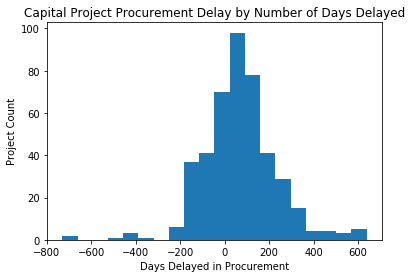

In [94]:
#plot histogram of delayed projects
pl.hist(data_delay_all,bins=20)
pl.legend()
pl.title("Capital Project Procurement Delay by Number of Days Delayed")
ylabel('Project Count')
xlabel('Days Delayed in Procurement')
pl.show()

### Fig 1. 
Historgram analysis of those projects that are delayed in the procurement process. Chart shows number of days delayed. 

Projects displaying negative numbers are ahead of schedule. This is the first instance to show where data integritiy might be in question. This is illustrated by some projects illustrating procurement completion times sooner than the standard 9 month period by a factor of 200+ days. Improvements of this magnitude are not possible, since legal review, soliciting of sealed bids, and registering projects takes longer than 70 days.

In [85]:
mean = data_delay_all.mean()


print ("Mean value: ") 
mean

Mean value: 


67.415525114155244

In [86]:
std = data_delay_all.std() 

print ("Standard deviation: ") 
std

Standard deviation: 


167.53874769168746

In [91]:
#Testing whether data is normal using T-Test
rvs1 = sp.norm.rvs(loc = mean,scale=std,size=500)
sp.ttest_ind(data_delay_all, rvs1, equal_var=False)

Ttest_indResult(statistic=-0.68949851964636155, pvalue=0.49068272460752105)

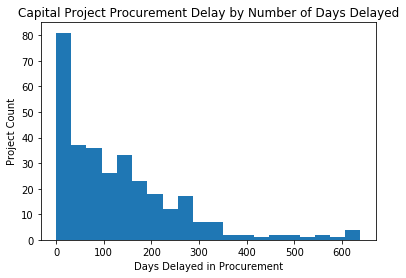

In [87]:
#plot histogram of ONLY delayed projects
pl.hist(plotdata,bins=20)
pl.legend()
pl.title("Capital Project Procurement Delay by Number of Days Delayed")
ylabel('Project Count')
xlabel('Days Delayed in Procurement')
pl.show()

### Fig 2. 
Historgram analysis of those projects that are delayed in the procurement process.

w

In [34]:
data.shape

(438, 39)

## 6. Clean and reframe for random forest analysis.

In [35]:
#Set data to appropriate shapes to fit into classifier
data_delay

,Boroughs,ConstructionActualCompletion,ConstructionAdjustedCompletion,ConstructionPercentComplete,ConstructionProjectedCompletion,ConstructionStart,CurrentPhase,DesignActualCompletion,DesignAdjustedCompletion,DesignPercentComplete,...,BOROUGH,ACRES,CLASS,JURISDICTI,NAME311,SUBCATEGOR,TYPECATEGO,ProjProDuration,ProjActualDuration,ProjDelay
0,{u'Borough': [u'Queens']},,,0.00,08/2017,03/2017,construction,09/2015,,100,...,Q,0.290,PARK,DPR,A.R.R.O.W. Field House,Greenthumb,Buildings/Institutions,153 days,153 days,0.0
2,"{u'Borough': [u'Bronx', u'Queens']}",,,79.00,04/2019,04/2016,construction,02/2014,01/2014,100,...,X,0.529,PARK,DPR,Abigail Playground,Neighborhood Plgd,Playground,273 days,759 days,486.0
3,"{u'Borough': [u'Manhattan', u'Queens', u'Brook...",,,0.00,09/2020,09/2017,construction,03/2015,07/2014,100,...,M,0.991,PLGD,DPR,Abraham Lincoln Playground,Neighborhood Plgd,Community Park,275 days,488 days,213.0
6,"{u'Borough': [u'Manhattan', u'Queens', u'Bronx...",06/2017,06/2017,100.00,09/2016,09/2013,completed,03/2011,,100,...,M,0.991,PLGD,DPR,Abraham Lincoln Playground,Neighborhood Plgd,Community Park,245 days,884 days,639.0
8,{u'Borough': [u'Queens']},10/2014,10/2014,100.00,01/2015,01/2013,completed,08/2011,07/2012,100,...,Q,0.759,PARK,DPR,Admiral Park,Neighborhood Plgd,Playground,274 days,366 days,92.0
9,{u'Borough': [u'Bronx']},,,4.50,07/2018,07/2017,construction,04/2016,04/2016,100,...,X,1.320,PARK,DPR/DOE,Agnes Haywood Playground,JOP,Jointly Operated Playground,275 days,426 days,151.0
10,{u'Borough': [u'Manhattan']},08/2015,08/2015,100.00,01/2013,01/2010,completed,03/2009,03/2009,100,...,M,0.811,PLGD,DPR,Alexander Hamilton Playground,Neighborhood Plgd,Playground,275 days,275 days,0.0
13,"{u'Borough': [u'Manhattan', u'Queens', u'State...",07/2017,07/2017,100.00,01/2014,01/2013,completed,12/2011,,100,...,M,1.750,PLGD,DPR/NYCHA,Alfred E. Smith Playground,Neighborhood Plgd,Community Park,275 days,305 days,30.0
14,{u'Borough': [u'Staten Island']},12/2013,12/2013,100.00,03/2014,03/2013,completed,01/2012,,100,...,R,15.524,PARK,DPR,Alice Austen Park,Large Park,Historic House Park,274 days,366 days,92.0
20,{u'Borough': [u'Bronx']},03/2017,03/2017,100.00,01/2017,07/2015,completed,06/2014,03/2014,100,...,X,1.597,PARK,DPR/DOE,Allerton Playground,JOP,Jointly Operated Playground,273 days,395 days,122.0


In [97]:
data_delay.BOROUGH.unique()

array(['Q', 'X', 'M', 'R', 'B'], dtype=object)

In [37]:
#create short dataframe to compare delayed against
data_delay_short = data_delay[['BOROUGH', 'ACRES', 'CLASS', 'TYPECATEGO']]
data_delay_short.head()

,BOROUGH,ACRES,CLASS,TYPECATEGO
0,Q,0.290,PARK,Buildings/Institutions
2,X,0.529,PARK,Playground
3,M,0.991,PLGD,Community Park
6,M,0.991,PLGD,Community Park
8,Q,0.759,PARK,Playground


In [38]:
data_delay_short_factor = data_delay_short.copy()

In [39]:
le = preprocessing.LabelEncoder()

In [40]:
columnHeaders = data_delay_short_factor.columns

In [41]:
for i in columnHeaders:
    columnData = data_delay_short[:][i]
    dedupedColumnData = columnData.drop_duplicates()
    le.fit(dedupedColumnData)
    factoredColumnData = le.transform(columnData)
    data_delay_short_factor[[i]] = factoredColumnData

In [42]:
data_delay_short_factor.head()

,BOROUGH,ACRES,CLASS,TYPECATEGO
0,2,10,0,0
2,4,24,0,10
3,1,49,1,1
6,1,49,1,1
8,2,37,0,10


In [43]:
data_delay['ProjDelay'].values.shape, data_delay_short_factor.values.shape

((314,), (314, 4))

## 7. Run random forest analysis.

In [44]:
ensemble.RandomForestClassifier

sklearn.ensemble.forest.RandomForestClassifier

In [45]:
#Run random forest analysis on small sample to determine significance levels
clf =  ensemble.RandomForestClassifier().fit(data_delay_short_factor.values, data_delay['ProjDelay'])
clf.score(data_delay_short_factor.values, data_delay['ProjDelay'])

0.71974522292993626

In [46]:
from sklearn import metrics, cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(data_delay_short_factor.values, 
                                                            data_delay['ProjDelay'], test_size=0.33, random_state=2000)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [47]:
#Run full analysis on full dataset
clf =  ensemble.RandomForestClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.038461538461538464

In [48]:
metrics.confusion_matrix(y_test, clf.predict(X_test))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [49]:
importances = clf.feature_importances_
importances

array([ 0.13699095,  0.62293085,  0.02310031,  0.21697789])

## 8. Plot significance levels.

Feature ranking:
1. feature 1 (0.622931)
2. feature 3 (0.216978)
3. feature 0 (0.136991)
4. feature 2 (0.023100)


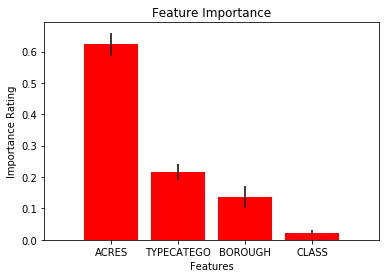

In [64]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
pl.figure()
pl.title("Feature Importance")
ylabel('Importance Rating')
xlabel('Features')
pl.bar(range(X_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
pl.xticks(range(X_test.shape[1]), data_delay_short_factor.columns[indices])
pl.xlim([-1, X_test.shape[1]])

pl.show()



### Fig 3. 
Illustration of significance for various feature types.

Size of the property (Acres) has the largest signicance when looking at project delays, whereas other features bear little to no significance in relation to delayed projects in the procurement process.